In [1]:
K = 15
P = "JAHELKA"
L = nchar(P)
M = ((K+L)*47)%%11 + 1
M

[1] 1

Vybraný reprezentant je Lukáš Jahelka.
Budeme tedy pracovat s datasetem číslo <b>1.</b>

In [2]:
library(eurostat)
library(ggplot2)
library(corrplot)
library(vtable)
library(cowplot)
library(moments)
library(e1071)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
corrplot 0.92 loaded

Loading required package: kableExtra


Attaching package: ‘e1071’


The following objects are masked from ‘package:moments’:

    kurtosis, moment, skewness




<h3><u>Úloha 1</u></h3>
Proveďte základní statistická šetření:

* Zkoumaná data stručně popište.
* Určete nejdůležitější statistické míry, které data nejlépe charakterizují.
* Vhodně data reprezentujte pomocí vybraných grafů.

In [3]:
search_eurostat(pattern='Population on 1 January by broad age group, sex and NUTS 3 region')

title,code,type,last update of data,last table structure change,data start,data end,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
"Population on 1 January by broad age group, sex and NUTS 3 region",demo_r_pjanaggr3,dataset,24.03.2023,20.03.2023,1990,2022,NA
"Population on 1 January by broad age group, sex and NUTS 3 region",demo_r_pjanaggr3,dataset,24.03.2023,20.03.2023,1990,2022,NA


In [4]:
id <- "demo_r_pjanaggr3"
data_copy <- get_eurostat(id=id)

Table demo_r_pjanaggr3 cached at /tmp/RtmpCe2N1J/eurostat/demo_r_pjanaggr3_date_code_FF.rds



In [5]:
head(data_copy)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,CH,2022-01-01,4400588
NR,F,TOTAL,CH0,2022-01-01,4400588
NR,F,TOTAL,CH01,2022-01-01,858921
NR,F,TOTAL,CH011,2022-01-01,418657
NR,F,TOTAL,CH012,2022-01-01,177734
NR,F,TOTAL,CH013,2022-01-01,262530


<b>Příprava dat</b>

Nejprve si vybereme regiony České republiky. Dataset dále vyfiltrujeme na údaje, které se vážou k roku 2021.

In [6]:
regiony <- c("CZ01", "CZ010", "CZ02", "CZ020", "CZ03", "CZ031", "CZ032", "CZ04", "CZ041", "CZ042", "CZ05", "CZ051", "CZ052", "CZ053", "CZ06", "CZ063", "CZ064", "CZ07", "CZ071", "CZ0720", "CZ08", "CZ080")

In [7]:
data <- data_copy[data_copy$geo %in% regiony,]
data <- data[data$time == "2021-01-01",]

<b>Vysvětlení příznaků</b>

* unit - jednotka měření
* sex - pohlaví
* age - věková kategorie
* geo - jednotlivé regiony
* time - čas měření
* values - počet obyvatel pro region

Počet sloupců v naší databázi je 6.
Počet záznámů je 315.

In [8]:
dim(data)

[1] 315   6

In [9]:
sum(is.na(data))

[1] 0

Vidíme, že tabulka neobsahuje žádné chybějící hodnoty, tudíž můžeme pokračovat. Z dat nejdříve vyhodíme řádky obsahující hodnotu "UNK" u sloupečku <b>age</b>, jelikož tyto příznaky neobsahují pro naši práci důležitou informaci.

In [10]:
data <- subset(data, age!="UNK")
head(data)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,CZ01,2021-01-01,681430
NR,F,TOTAL,CZ010,2021-01-01,681430
NR,F,TOTAL,CZ02,2021-01-01,706011
NR,F,TOTAL,CZ020,2021-01-01,706011
NR,F,TOTAL,CZ03,2021-01-01,622726
NR,F,TOTAL,CZ031,2021-01-01,325503


Nastavíme diskrétní hodnoty na factor a rozdělíme si tabulku na muže a ženy.

In [11]:
data$sex <- as.factor(data$sex)
data$age <- as.factor(data$age)
summary(data)

     unit           sex        age         geo                 time           
 Length:252         F:84   TOTAL :63   Length:252         Min.   :2021-01-01  
 Class :character   M:84   Y_GE65:63   Class :character   1st Qu.:2021-01-01  
 Mode  :character   T:84   Y_LT15:63   Mode  :character   Median :2021-01-01  
                           Y15-64:63                      Mean   :2021-01-01  
                                                          3rd Qu.:2021-01-01  
                                                          Max.   :2021-01-01  
     values       
 Min.   :  21680  
 1st Qu.: 102026  
 Median : 205086  
 Mean   : 330531  
 3rd Qu.: 440379  
 Max.   :1704179  

In [12]:
females <- subset(data, sex=="F", select=c("geo", "age", "values"))
colnames(females) <- c("geo", "age", "females")
males <- subset(data, sex=="M", select=c("geo", "age", "values"))
colnames(males) <- c("geo", "age", "males")

In [13]:
summary(females)

     geo                age        females      
 Length:84          TOTAL :21   Min.   : 21680  
 Class :character   Y_GE65:21   1st Qu.: 91766  
 Mode  :character   Y_LT15:21   Median :149107  
                    Y15-64:21   Mean   :251376  
                                3rd Qu.:375624  
                                Max.   :863564  

In [14]:
summary(males)

     geo                age         males       
 Length:84          TOTAL :21   Min.   : 22838  
 Class :character   Y_GE65:21   1st Qu.: 94818  
 Mode  :character   Y_LT15:21   Median :141005  
                    Y15-64:21   Mean   :244420  
                                3rd Qu.:390700  
                                Max.   :840615  

Po aplikaci funkce summary pro muže a ženy, kde zvažujeme všechny věkové kategorie se zdá, že jsou muži i ženy podobně rozprostřeni. Jednotlivé údaje jako minimum, maximum, průměr... se liší minimálně, v řádech tisíců. To by mělo odpovídat i měření v rámci "sčítání lidu" z roku 2021.

In [15]:
summary(females[females$age=="Y_GE65",])

     geo                age        females      
 Length:21          TOTAL : 0   Min.   : 34795  
 Class :character   Y_GE65:21   1st Qu.: 69712  
 Mode  :character   Y_LT15: 0   Median :141264  
                    Y15-64: 0   Mean   :115498  
                                3rd Qu.:148218  
                                Max.   :201681  

In [16]:
summary(males[males$age=="Y_GE65",])

     geo                age         males       
 Length:21          TOTAL : 0   Min.   : 25989  
 Class :character   Y_GE65:21   1st Qu.: 52918  
 Mode  :character   Y_LT15: 0   Median : 99374  
                    Y15-64: 0   Mean   : 84222  
                                3rd Qu.:105464  
                                Max.   :145964  

Když se ale podíváme na obyvatele starší 65 let, tak nastávájí větší rozdíly mezi pohlavími. Například si můžeme všimnout výrazného rozdílu hodnot mediánů (ženy - 141264, muži - 99374). Díky tomu můžeme předpokládat, že ženy žijí déle jak muži. 

In [17]:
summary(females[females$age=="Y_LT15",])

     geo                age        females      
 Length:21          TOTAL : 0   Min.   : 21680  
 Class :character   Y_GE65: 0   1st Qu.: 45197  
 Mode  :character   Y_LT15:21   Median : 89494  
                    Y15-64: 0   Mean   : 77837  
                                3rd Qu.:103743  
                                Max.   :133249  

In [18]:
summary(males[males$age=="Y_LT15",])

     geo                age         males       
 Length:21          TOTAL : 0   Min.   : 22838  
 Class :character   Y_GE65: 0   1st Qu.: 47103  
 Mode  :character   Y_LT15:21   Median : 94275  
                    Y15-64: 0   Mean   : 81727  
                                3rd Qu.:109081  
                                Max.   :139822  

Pro zajímavost vypíšeme obyvatele mladší 15 let. Hodnoty statistických měr jsou opět vyrovnané.

In [19]:
print(var(females$females))

[1] 44897988567


In [20]:
print(var(males$males))

[1] 45005278560


Nakonec data ještě spojíme do jednoho výsledného dataframu.

In [21]:
df <- merge(females,males)
head(df)

,geo,age,females,males
,<chr>,<fct>,<dbl>,<dbl>
1,CZ01,TOTAL,681430,653654
2,CZ01,Y_GE65,148218,104893
3,CZ01,Y_LT15,103743,109081
4,CZ01,Y15-64,429469,439680
5,CZ010,TOTAL,681430,653654
6,CZ010,Y_GE65,148218,104893


<h3>Vizualizace</h3>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Package `gridGraphics` is required to handle base-R plots. Substituting empty plot.”


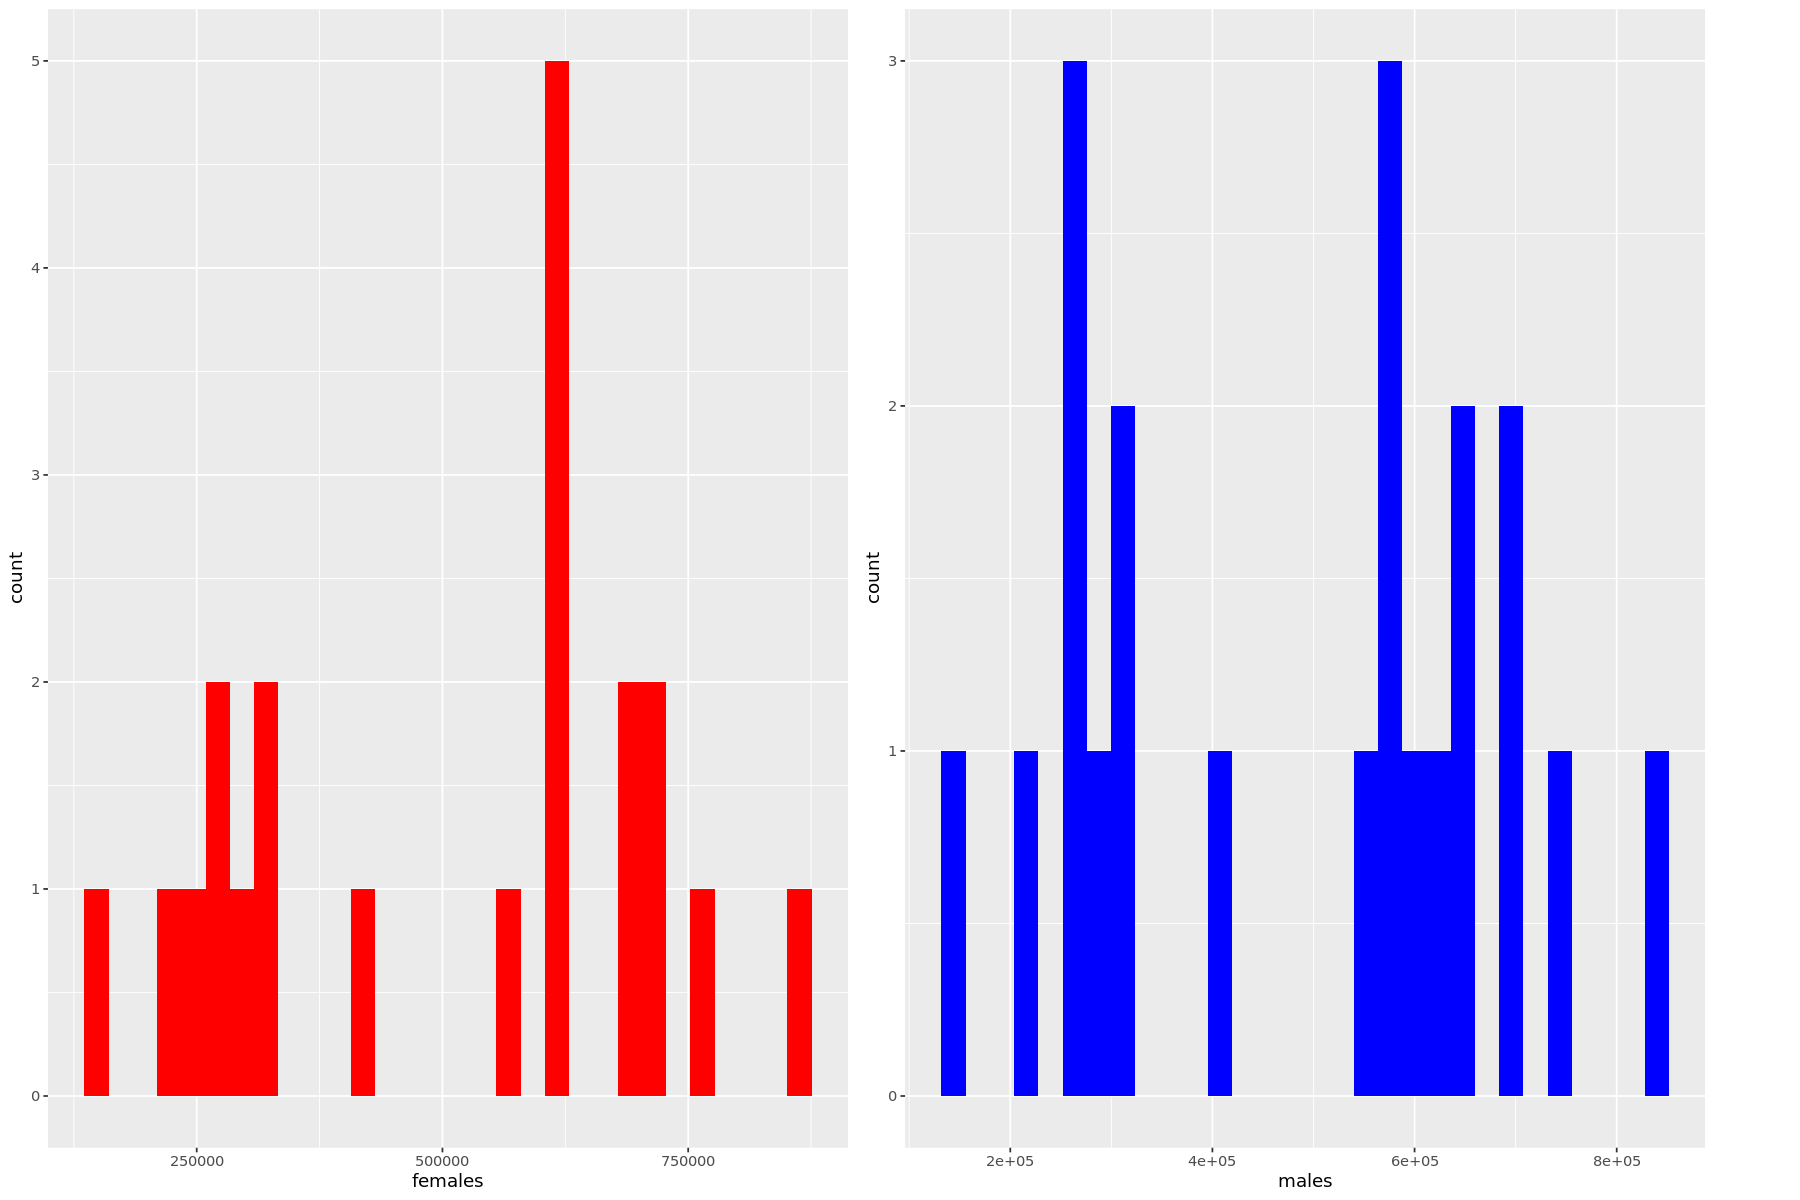

In [22]:
p1 <- ggplot(df[df$age == "TOTAL",], aes(x=females)) +
    geom_histogram(fill = "red")
p2 <- ggplot(df[df$age == "TOTAL",], aes(x=males)) +
    geom_histogram(fill = "blue")
pg <- plot_grid(p1 + theme(legend.position="none"), 
                p2 + theme(legend.position="none"), 
                nrow=1)

options(repr.plot.width=15, repr.plot.height=10)
plot_grid(pg, legend, rel_widths = c(2, .1))

<b>Pozorování:</b>

U žen můžeme vidět velký nárust u středu grafu, což může připomínat normální rozdělení. Na tuto hypotézu se podíváme podrobněji níže. <br>
U mužů nedokážeme odhadnout o jaké rozdělení se jedná.

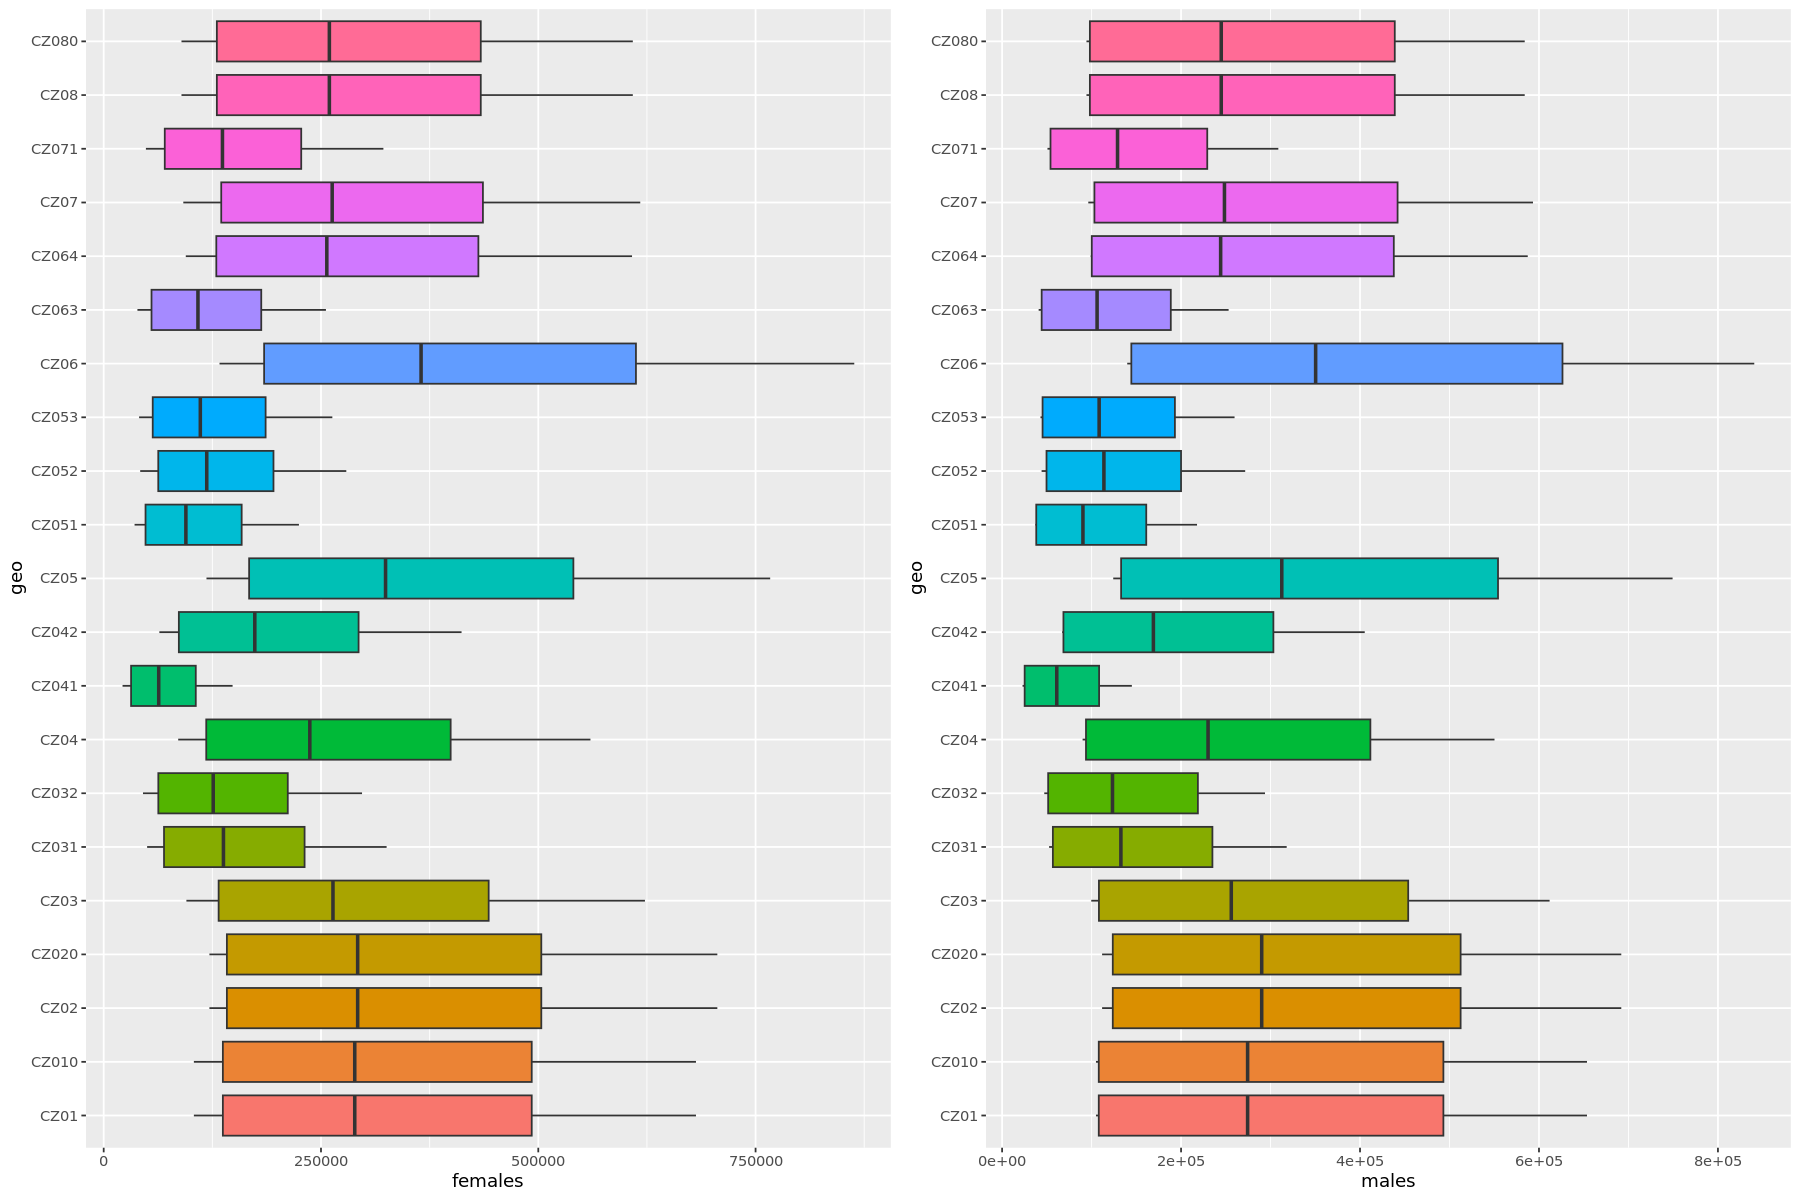

In [23]:
p1 <- ggplot(df, aes(x=females, y=geo, fill=geo)) +
        geom_boxplot(outlier.color="red", show.legend=F)
p2 <- ggplot(df, aes(x=males, y=geo, fill=geo)) +
        geom_boxplot(outlier.color="red", show.legend=F)
plot_grid(p1, p2, nrow=1)

Z box plotu vidíme, že rozdělení mužů a žen v každém kraji je doopravdy téměř totožné.

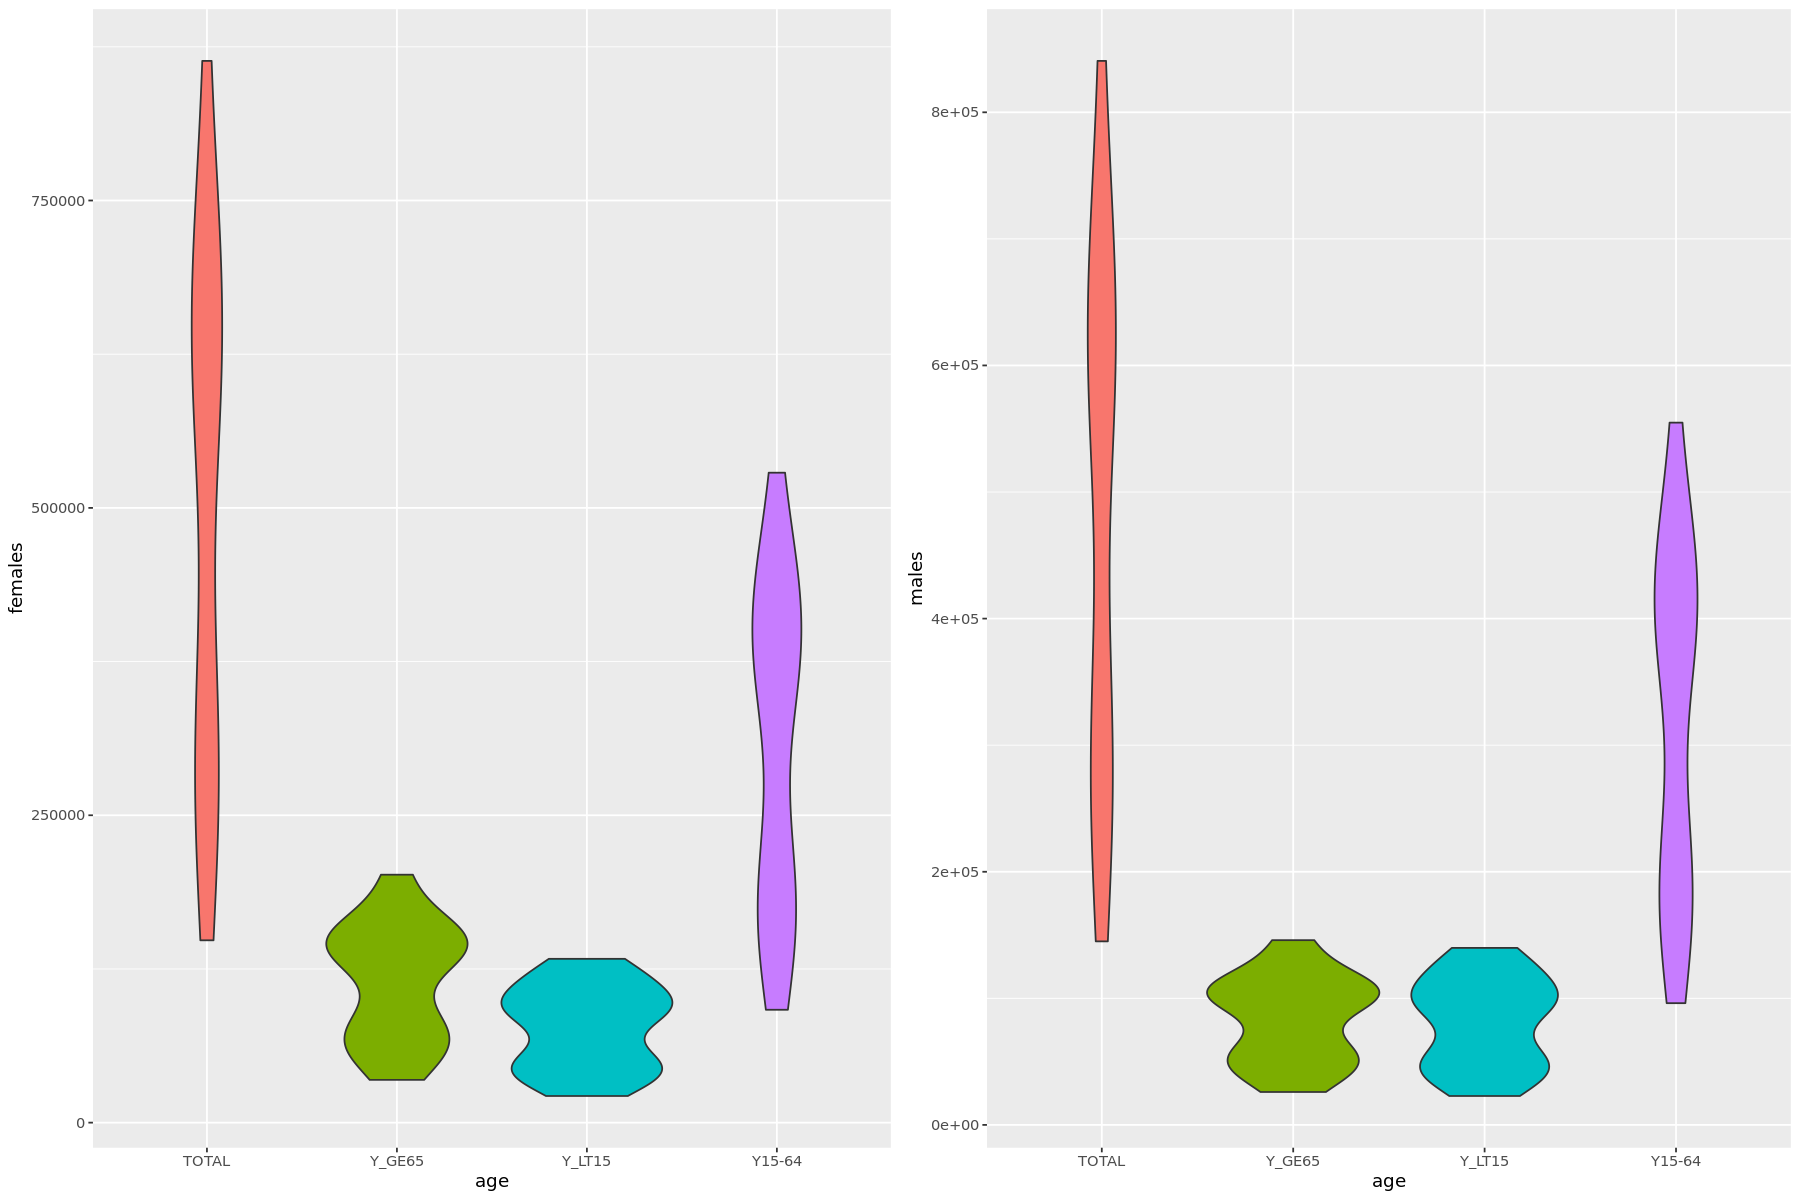

In [24]:
p1 <- ggplot(df, aes(x=age, y=females, fill=age)) +
        geom_violin(show.legend=F)
p2 <- ggplot(df, aes(x=age, y=males, fill=age)) +
        geom_violin(show.legend=F)
plot_grid(p1, p2, nrow=1)

Z grafu lze vidět, že žen nad 65 let je více jak mužů, což odpovídá našemu předpokladu u statistických měr. Ostatní grafy si jsou velmi podobné.

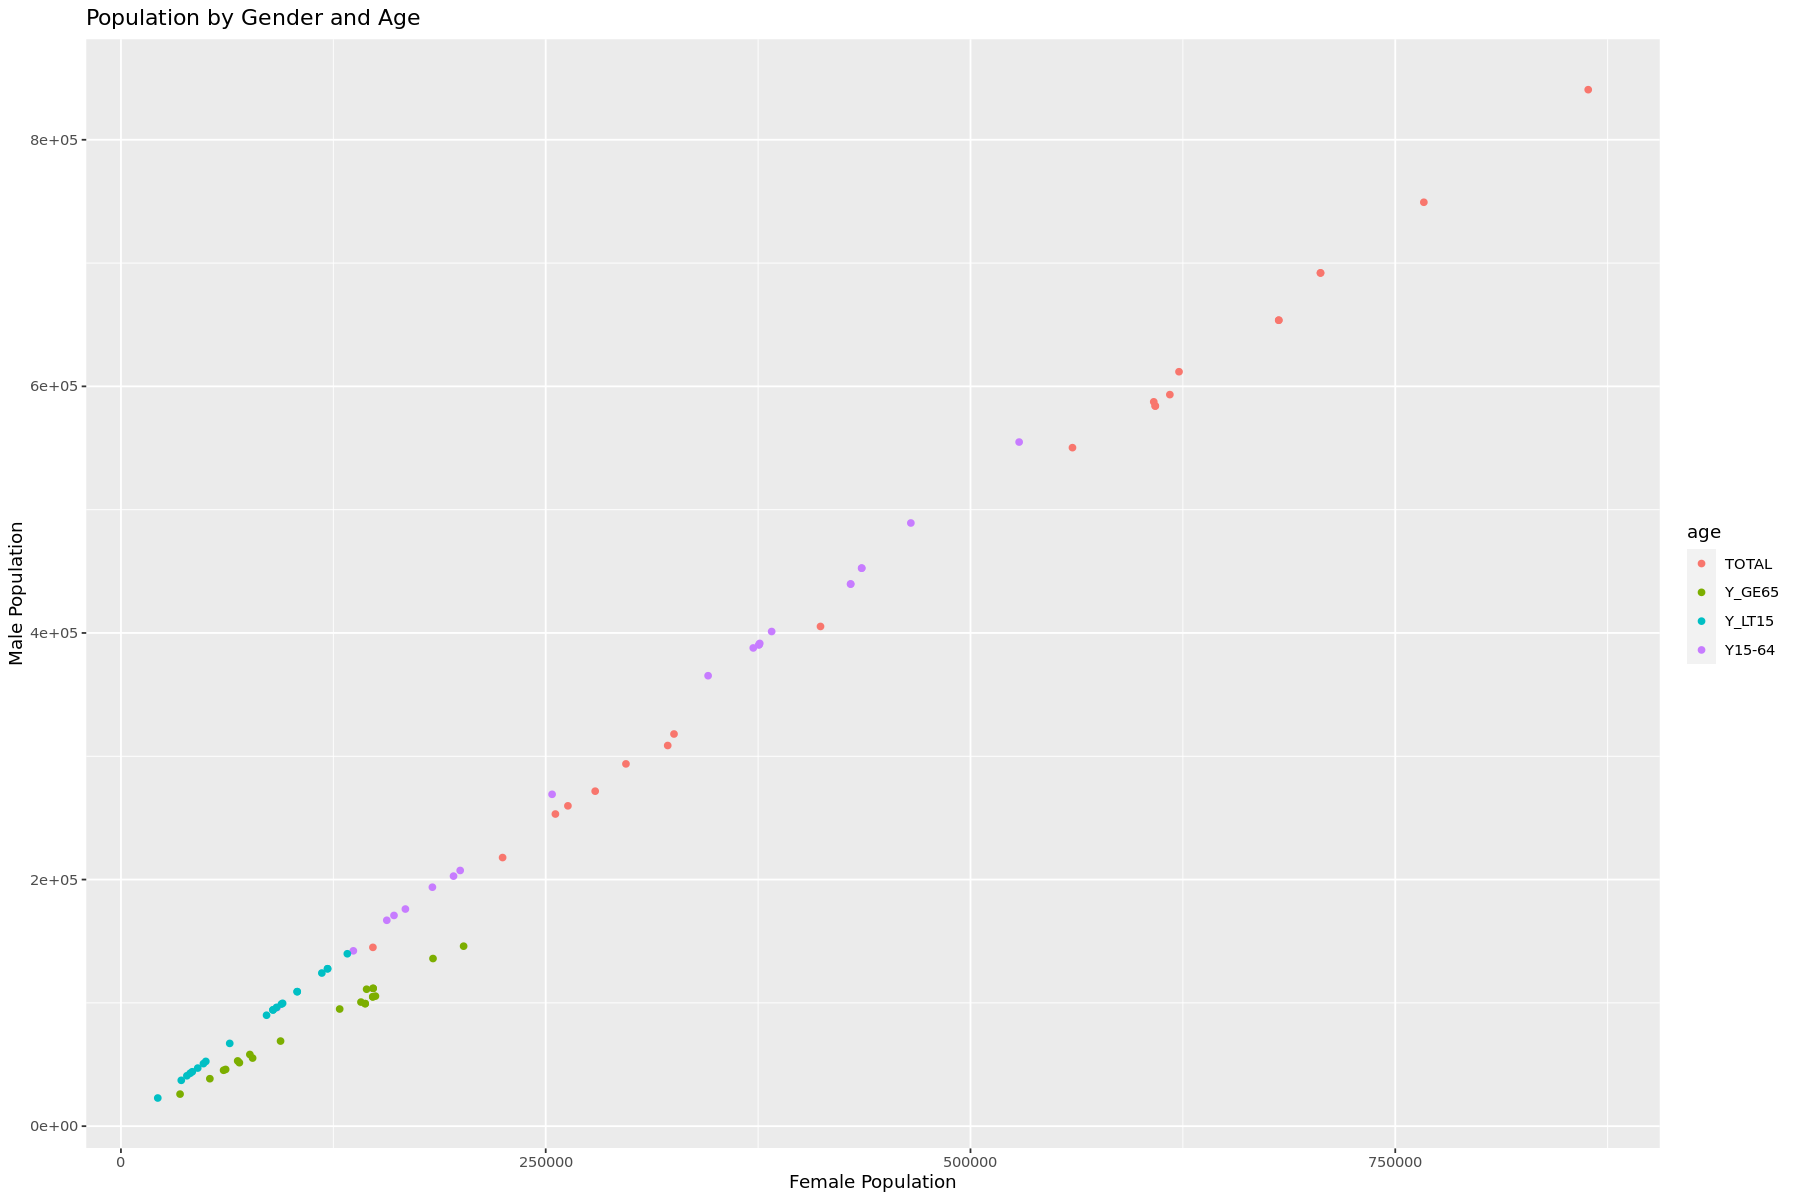

In [25]:
ggplot(df, aes(x = females, y = males, color = age)) +
  geom_point() +
  labs(x = "Female Population", y = "Male Population", title = "Population by Gender and Age")
options(repr.plot.width=12, repr.plot.height=10)

Nakonec potvrzujeme naši domněnku o rovnoměrném rozdělení mužů a žen v jednotlivých věkových rozdělení, až na kategorii 65 let a více (vychýlení na stranu žen).

<h3><u>Úloha 2</u></h3>
Na základě povahy zkoumaných dat navrhněte tři dvojice (H0 a HA) potenciálně zajímavých hypotéz vedoucích na tři různé statistické testy (jiné než v úloze 3):

* Hypotézy můžete sestavovat s ohledem na konkrétní data, ale je vhodné brát i informace např. z celoevropského rámce (průměrný počet obyvatel NUTS 3 oblastí EU apod.).
* Vysvětlete, jaké testy jste vybrali a proč.
* Testy hypotéz proveďte a interpretujte jejich výsledky, jak po matematické tak po praktické stránce.

<b>Je populace žen a mužů z normálního rozdělení?</b>

* nulová hypotéza: data jsou z normálního rozdělení
* alternativní hypotéza: data nejsou z normálního rozdělení

In [26]:
shapiro.test(df$females)


	Shapiro-Wilk normality test

data:  df$females
W = 0.85309, p-value = 1.199e-07


In [27]:
shapiro.test(df$males)


	Shapiro-Wilk normality test

data:  df$males
W = 0.84791, p-value = 7.962e-08


Jelikož p hodnota obou testů je menší než 0.1,  hypotézu <b>zamítáme</b> v obou případech. Pro zajímavost vykreslíme QQPLOT, kde vidíme, že hodnoty neleží na přímce.

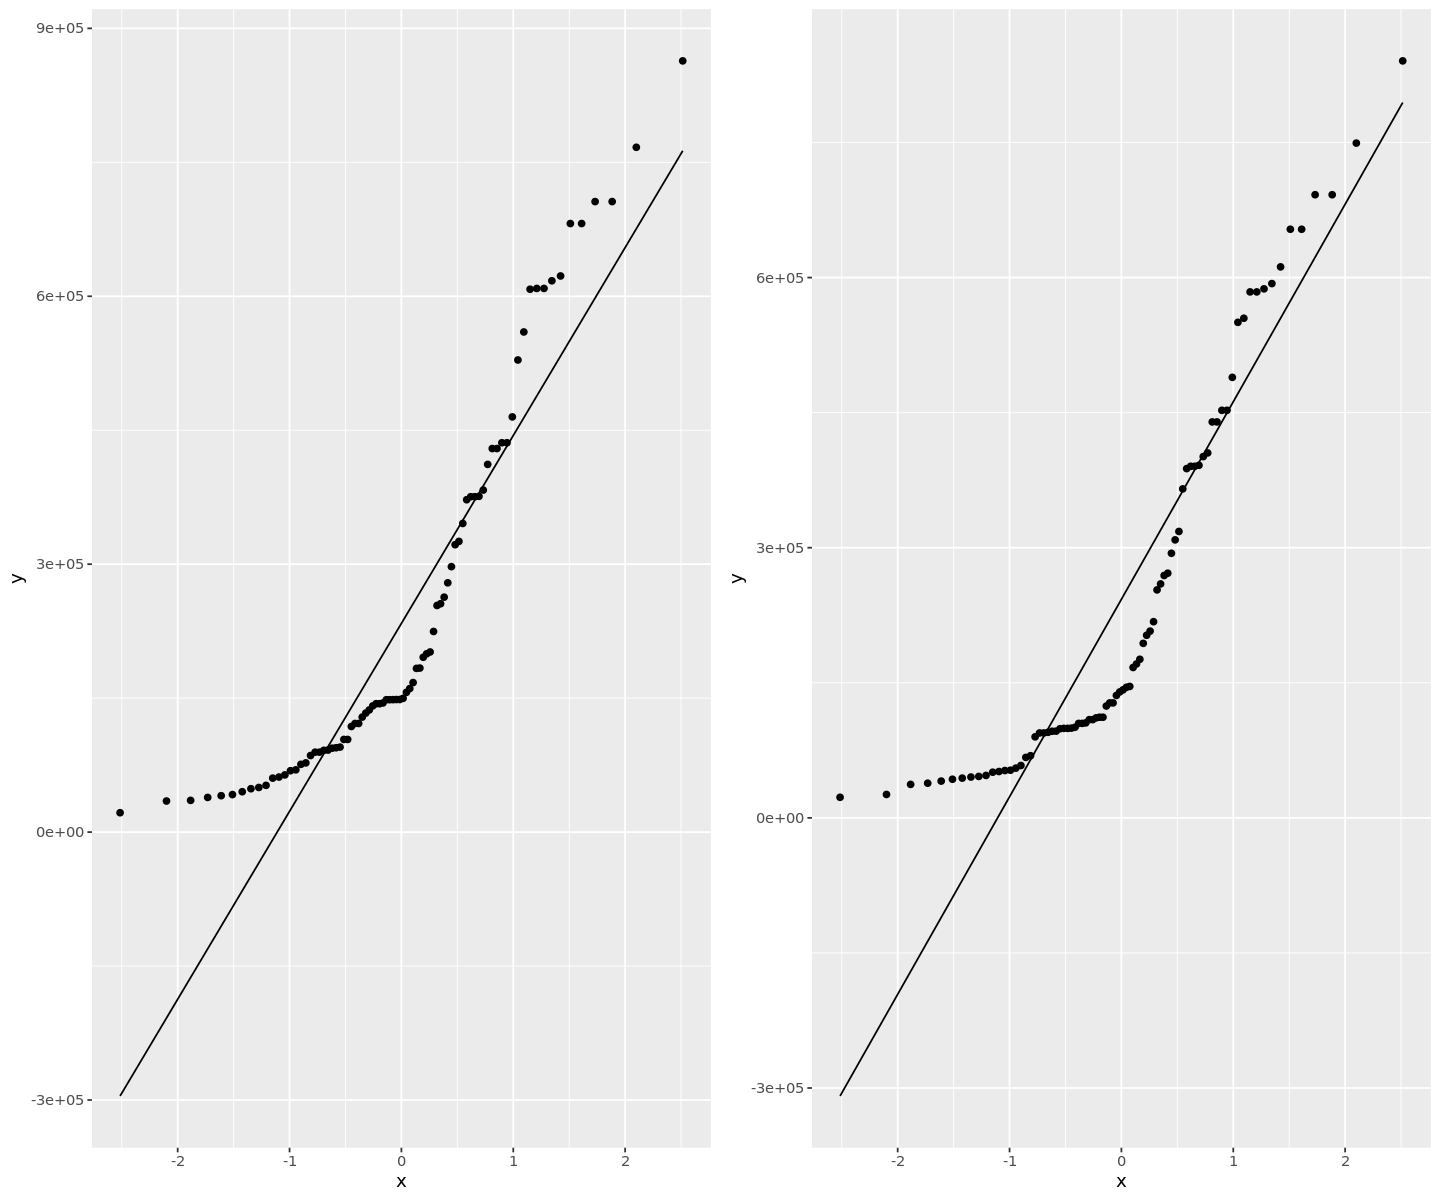

In [28]:
p1 <- ggplot(df, aes(sample=females)) +
        stat_qq(distribution=stats::qnorm, show.legend=T) +
        stat_qq_line(distribution=stats::qnorm, show.legend=F)
p2 <- ggplot(df, aes(sample=males)) +
        stat_qq(distribution=stats::qnorm, show.legend=T) +
        stat_qq_line(distribution=stats::qnorm, show.legend=F)
plot_grid(p1, p2, nrow=1)

<b>Je střední hodnota mužů a žen stejná?</b>

* nulová hypotéza: střední hodnota mužů a žen je stejná
* alternativní hypotéza: střední hodnota mužů a žen není stejná

Nejprve musíme otestovat, zda mají stejný rozptyl.

In [29]:
var.test(df$females, df$males, conf.level = 0.95)


	F test to compare two variances

data:  df$females and df$males
F = 0.99762, num df = 83, denom df = 83, p-value = 0.9914
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.6468609 1.5385655
sample estimates:
ratio of variances 
         0.9976161 


Jelikož p hodnota je větší jak alpha (5%), hypotézu <b>nezamítáme</b> a pokračujeme dále.

In [30]:
t.test(df$females, df$males, var.equal = TRUE, alternative = "two.sided", conf.level = 0.95)


	Two Sample t-test

data:  df$females and df$males
t = 0.21265, df = 166, p-value = 0.8319
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -57634.31  71548.26
sample estimates:
mean of x mean of y 
 251376.5  244419.5 


Test vyšel, nulovou hypotézu <b>nezamítáme</b>.

<b>Tvoří muži 50% populace v každém regionu?</b>

* nulová hypotéza: v každém regionu je distribuce žen a můžů stejná
* alternativní hypotéza: v každém regionu není distribuce žen a můžů stejná

In [31]:
dt <- df[df$age == "TOTAL",]
prop_male <- dt$males / (dt$males + dt$females)
test_data <- data.frame(region = dt$geo, prop_male = prop_male)

Vytvoříme si vektor pravděpodobností pro každý region (těch je 21). Součet pravděpodobností musí být 1, proto pravděpodobnost každého regionu musí být 1/21 (to přesně odpovídá nulové hypotéze).

In [32]:
p <- rep(1/21, nrow(test_data))
chisq.test(x = test_data$prop_male, p = p)

Warning message in chisq.test(x = test_data$prop_male, p = p):
“Chi-squared approximation may be incorrect”



	Chi-squared test for given probabilities

data:  test_data$prop_male
X-squared = 0.0003121, df = 20, p-value = 1


Z hodnoty p nulovou hypotézu <b>nezamítáme</b>.

<b>Změnila se střední hodnota počtu žen za posledních 10 let?</b>

* nulová hypotéza: střední hodnota se nezměnila
* alternativní hypotéza: střední hodnota se změnila

Nejprve si připravíme data z roku 2011.

In [33]:
data2011 <- data_copy[data_copy$geo %in% regiony,]
data2011 <- data2011[data2011$time == "2011-01-01",]

In [34]:
data2011$sex <- as.factor(data2011$sex)
data2011$age <- as.factor(data2011$age)

In [35]:
females2011 <- subset(data2011, sex=="F", select=c("geo", "age", "values"))
colnames(females2011) <- c("geo", "age", "females")

In [36]:
var.test(females2011$females, df$females, conf.level = 0.95)


	F test to compare two variances

data:  females2011$females and df$females
F = 1.0488, num df = 104, denom df = 83, p-value = 0.8256
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.6923615 1.5736524
sample estimates:
ratio of variances 
          1.048818 


Jelikož p hodnota je větší jak alpha (5%), hypotézu, že mají stejný rozptyl, <b>nezamítáme</b> a pokračujeme dále.

In [37]:
t.test(df$females, females2011$females, var.equal = TRUE, alternative = "two.sided", conf.level = 0.95)


	Two Sample t-test

data:  df$females and females2011$females
t = 1.7086, df = 187, p-value = 0.08918
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  -8303.006 115726.453
sample estimates:
mean of x mean of y 
 251376.5  197664.8 


Test vyšel, nulovou hypotézu <b>nezamítáme</b>.

<h3><u>Úloha 3</u></h3>

* Sestavte kontingenční tabulku počtů obyvatel podle pohlaví a NUTS 3 oblastí.
* Tuto tabulku interpretujte, navrhněte hypotézy o jejích vlastnostech a proveďte příslušný test.
* Interpretujte jeho výsledky.

Z datasetu si vybereme pouze kraje, aby jsme nepočítali některé hodnoty dvakrát (například CZ01 = "Praha", CZ010 = "hlavní město Praha").

In [38]:
kraje <- c("CZ010", "CZ020", "CZ031", "CZ032", "CZ041", "CZ042", "CZ051", "CZ052", "CZ053", "CZ063", "CZ064", "CZ071", "CZ0720", "CZ080")

data_kraje <- data_copy[data_copy$geo %in% kraje,]
data_kraje <- data_kraje[data_kraje$time == "2021-01-01",]

data_kraje <- subset(data_kraje, age!="UNK")

data_kraje$sex <- as.factor(data_kraje$sex)
data_kraje$age <- as.factor(data_kraje$age)

females <- subset(data_kraje, sex=="F", select=c("geo", "age", "values"))
colnames(females) <- c("geo", "age", "females")
males <- subset(data_kraje, sex=="M", select=c("geo", "age", "values"))
colnames(males) <- c("geo", "age", "males")

In [39]:
contg <- data_kraje[data_kraje$sex %in% c("F", "M"),]
contg <- droplevels(contg)

In [40]:
ct <- xtabs(formula=values ~ sex + geo, data=contg)
ct

   geo
sex   CZ010   CZ020   CZ031   CZ032   CZ041   CZ042   CZ051   CZ052   CZ053
  F 1362860 1412022  651006  594446  296596  823454  449258  558246  526134
  M 1307308 1383972  636096  587636  290026  810554  435694  543360  519578
   geo
sex   CZ063   CZ064   CZ071   CZ080
  F  511398 1215730  643608 1217522
  M  506306 1174924  617436 1168146

In [41]:
addmargins(ct)

,CZ010,CZ020,CZ031,CZ032,CZ041,CZ042,CZ051,CZ052,CZ053,CZ063,CZ064,CZ071,CZ080,Sum
F,1362860,1412022,651006,594446,296596,823454,449258,558246,526134,511398,1215730,643608,1217522,10262280
M,1307308,1383972,636096,587636,290026,810554,435694,543360,519578,506306,1174924,617436,1168146,9981036
Sum,2670168,2795994,1287102,1182082,586622,1634008,884952,1101606,1045712,1017704,2390654,1261044,2385668,20243316


Kontingenční tabulka.

In [42]:
addmargins(prop.table(ct))

,CZ010,CZ020,CZ031,CZ032,CZ041,CZ042,CZ051,CZ052,CZ053,CZ063,CZ064,CZ071,CZ080,Sum
F,0.06732395,0.06975250,0.03215906,0.02936505,0.01465155,0.04067782,0.02219291,0.02757681,0.02599050,0.02526256,0.06005587,0.03179361,0.06014440,0.5069466
M,0.06457974,0.06836686,0.03142252,0.02902864,0.01432700,0.04004057,0.02152286,0.02684145,0.02566664,0.02501102,0.05804010,0.03050073,0.05770527,0.4930534
Sum,0.13190369,0.13811937,0.06358158,0.05839369,0.02897855,0.08071840,0.04371576,0.05441826,0.05165715,0.05027358,0.11809597,0.06229434,0.11784966,1.0000000


Zde vidíme marginální pravděpodobnosti. Můžeme si povšimnout, že pro muže i ženy jsou pravděpodobnosti vždy skoro stejné.

<b>Jsou příznaky pohlaví a region nezávislé?</b>

* nulová hypotéza: pohlaví a region jsou nezávislé
* alternativní hypotéza: pohlaví a region nejsou nezávislé

In [43]:
chisq.test(ct)


	Pearson's Chi-squared test

data:  ct
X-squared = 654.54, df = 12, p-value < 2.2e-16


Nulovou hypotézu <b>zamítáme</b> ve prospěch alternativní.